<a href="https://colab.research.google.com/github/leosilvinob/Song-Lyrics-Generator/blob/main/Lyrics%20Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax, SGD, RMSprop
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")

In [3]:
def get_df():
    df=pd.DataFrame()
    for file in os.listdir():
          if file.endswith('.csv'):
              aux=pd.read_csv(file)
              df=df.append(aux)
    return df
df=get_df()

In [4]:
df.head()

,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0.0,Coldplay,The Scientist,A Rush of Blood to the Head,2002,2002-08-26,come up to meet you tell you i'm sorry you don...
1,1.0,Coldplay,Viva la Vida,Viva La Vida or Death and All His Friends,2008,2008-05-25,chris martin i used to rule the world seas wou...
2,2.0,Coldplay,Fix You,X&Y,2005,2005-06-06,chris martin when you try your best but you do...
3,3.0,Coldplay,Yellow,Parachutes,2000,2000-06-26,chris martin look at the stars look how they s...
4,4.0,Coldplay,Hymn for the Weekend,A Head Full of Dreams,2016,2016-01-25,beyoncé and said drink from me drink from me o...


In [5]:
df.shape

(6027, 7)

# Exploração de data
Nessa seção vai ser realizado

*   Exploração de diversos artista no dataser
*   Explorar o número de músicas e suas respectivas informações
*   Explorar as palavras das letras por meio da wordcloud







In [6]:
print("Artistas no dataset:\n",df.Artist.value_counts()) 

Artistas no dataset:
 Eminem           521
Taylor Swift     479
Drake            466
Beyoncé          406
Rihanna          405
Lady Gaga        402
Justin Bieber    348
Coldplay         344
Katy Perry       325
Nicki Minaj      323
Ariana Grande    308
Ed Sheeran       296
BTS (방탄소년단)      278
Dua Lipa         247
Maroon 5         197
Selena Gomez     175
Post Malone      148
Billie Eilish    145
Charlie Puth      75
Cardi B           75
Khalid            64
Name: Artist, dtype: int64


In [7]:
#Printing do tamanho do dataset
print("Tamanho do dataset:",df.shape)

Tamanho do dataset: (6027, 7)


In [8]:
df.duplicated(subset = 'Artist', keep = 'first').value_counts()

True     6006
False      21
dtype: int64

In [9]:
df.drop_duplicates(subset='Lyric', keep='first', inplace=True, ignore_index=False)

In [10]:
#Corrigindo valores que questão faltando, ou eles são considerados como 'float',
#o que pode atrapalhar quando usamos funções que só aceitam 'object'
df = df.replace('', np.nan)
df = df.dropna()

In [11]:
# Deletar as colunas que não serão necessárias
df.drop(['Unnamed: 0','Title','Album','Year','Date'],axis=1,inplace=True)

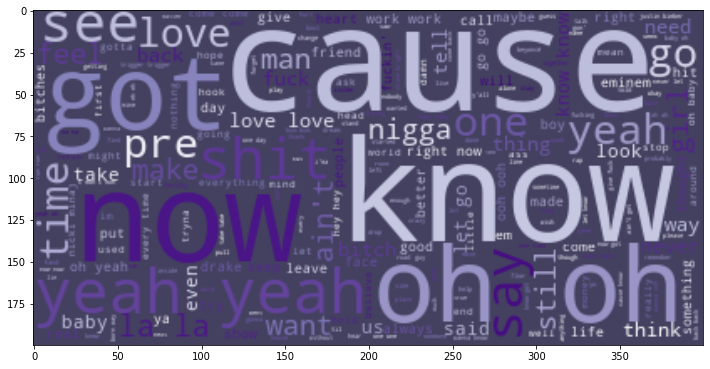

In [12]:
# Gerando uma núvem de palavram com base nas Letras que temos
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(df["Lyric"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3162 entries, 0 to 403
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Artist  3162 non-null   object
 1   Lyric   3162 non-null   object
dtypes: object(2)
memory usage: 74.1+ KB


In [14]:
#Deletando linhas que tenham valores duplicados
df = df[~df.index.duplicated()]

In [15]:
import nltk
nltk.download('punkt')
df["No_of_Characters"] = df["Lyric"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["Lyric"]), axis=1).apply(len)
df.describe()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,No_of_Characters,No_of_Words
count,454.000000,454.000000
mean,1828.548458,394.345815
std,1467.696813,319.027588
min,10.000000,1.000000
25%,805.250000,172.000000
50%,1235.000000,258.000000
75%,2551.750000,572.250000
max,8673.000000,1818.000000


<Figure size 1080x72 with 0 Axes>

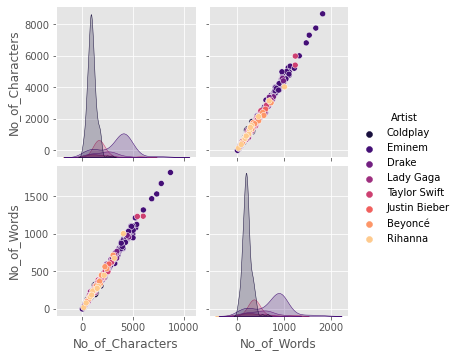

In [41]:
#Gráfico comparativa do tamanho das músicas em relação aos artistas
plt.figure(figsize=(15,1))
ax = sns.pairplot(df, hue="Artist", palette="magma")

Text(0.5, 1.0, 'Distribuição da frequência do número de palavras por música extraída')

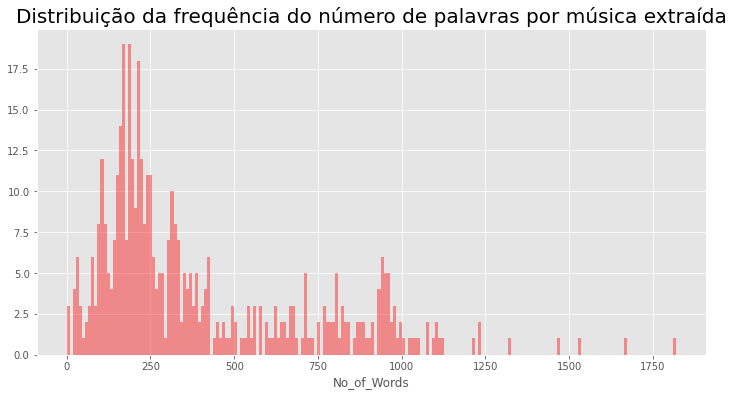

In [17]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['No_of_Words'],kde = False,color="red",bins=200)
plt.title("Distribuição da frequência do número de palavras por música extraída", size=20)

# Pré processamento do Dataset
Nesta seção vai ser realizado o seguinte:

* Criando um corpus de Letras Musicais: Para o modelo é preciso uma string de texto. Vai ser criado um Corpus a partir da coluna 'Lyric'

* Removendo os caracteres não necessários no Corpus: Etapa importante para qualquer algoritimo de NLP, para realizar essa limpeza, vai ser checado se o Corpus está comprometido, verificar caracteres únicos ou simbolos irrelevantes.

* Criação de um dicionário para mapear os caracteres e seus índiices: O computador não entede texto, ele lê como simbolos, então vai ser criado um dicionário para a mapeação de de caracteres únicos em forma de número. Isso vai ser usado para codificar e decodificar a informação que está indo e voltando do RNN.

* Divisão do Corpus em sequências menores de tamanho igual: Esse Corpus vai ser codificado e criado sequências menores de tamanho igual de recursos e os alvos correspondentes. Cada recurso e alvo vai conter o indice mapeado no dicinário de caracteres.

As sequências são então redimensionados e normalizados. Onde os alvos recebem one-hot, transformado-se assim em array. Prontos para serem mandados para o modelo RNN para treinamento, mas antes vai ser construído o modelo RNN.



# Criando o Corpus

In [18]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in df.Lyric:
    Corpus += listitem
    
Corpus = Corpus.lower() #converting all alphabets to lowecase 
print("Número de caracteres únicos:", len(set(Corpus)))

Número de caracteres únicos: 80


In [19]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: [' ', "'", '0', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'á', 'ä', 'è', 'é', 'ê', 'í', 'ñ', 'ó', 'ú', 'ü', 'ι', 'е', 'آ', 'أ', 'ا', 'ب', 'ة', 'ت', 'ح', 'د', 'ذ', 'ر', 'ز', 'ش', 'ض', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'چ', 'ک', 'گ', 'ی', '\u2005', '\u200a', '\u2028', '\u205f']


In [20]:
to_remove = ["'",'ی','\xa0', 'á', 'ä', 'è', 'é', 'ê', 'í', 'ñ', 'ó', 'ú', 'ü', 'ι','\u2005', '\u200a', '\u2028', '\u205f',
 'أ', 'ا', 'ب', 'ة', 'ت', 'ح', 'د', 'ذ', 'ر', 'ز', 'ش', 'ض', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي', 'چ', 'ک', 'گ ','آ']
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

In [21]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: [' ', '0', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'е']


# Criação de uma lista de caracteres únicos

In [22]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 830156
Number of unique characters: 35


# Dividindo o corpus em tamanho igual de strings

---



In [23]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

In [24]:
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 830116


# Codificando os recursos e alvos

In [25]:
# Remodelando X e normalizando
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode a variável de output
y = np_utils.to_categorical(targets)

# Construindo o modelo
Vai ser construindo um modelo RNN, especificamente um modelo LSTM, este tipo de modelo de a capacidadede de processar sequências inteiras de dados.

As seguintes etapas estarão envolvidas:
* Inicializar o modelo
* Difinição e adição de camadas neurais
* Compilação do modelo
* Treinamento do modelo

# Construindo o modelo

In [26]:
#Inicialização do modelo
model = Sequential()
#Adição de camadas neurais
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compilação do modelo para treinamento  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

               
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 35)                8995      
Total params: 273,187
Trainable params: 273,187
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
6486/6486 [==============================] - 1479s 228ms/step - loss: 2.4838
Epoch 2/10
6486/6486 [==============================] - 1484s 229ms/step - loss: 2.1818
Epoch 3/10
6486/6486 [==============================] - 1536s 237ms/step - loss: 2.0232
Epoch 4/10
6486/6486 [==============================] - 2010s 310ms/step - loss: 1.9277
Epoch 5/10
6486/6486 [==============================] - 1468s 226ms/step - loss: 1.8601
Epoch 6/10
6486/6486 [==============================] - 1474s 227ms/step - loss: 1.8092
Epoch 7/10
6486/6486 [==============================] - 1766s 272ms/step - loss: 1.7712
Epoch 8/10
6486/6486 [==============================] - 1603s 247ms/step - loss: 1.7344
Epoch 9/10
6486/6486 [==============================] - 1479s 228ms/step - loss: 1.7090
Epoch 10/10
6486/6486 [==============================] - 1479s 228ms/step - loss: 1.6809


[Text(0.5, 0, 'Epochs')]

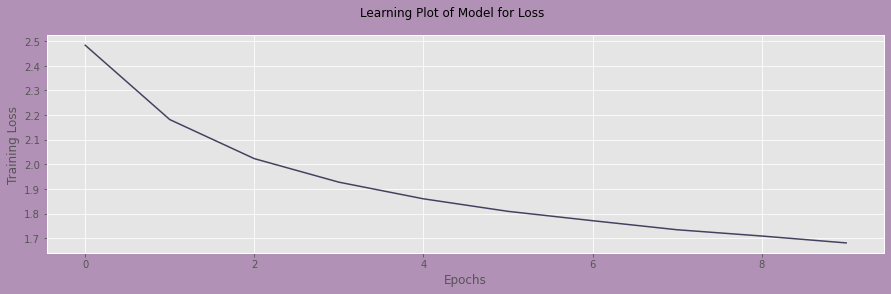

In [28]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [29]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter 
    seed=[mapping[char] for char in starter]
    generated += starter 
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0 
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char
       
    return generated

In [37]:
#Gerando uma música a partir do modelo
song_1 = Lyrics_Generator("well you done done me in you bet i felt i", 400)
#Let's have a look at the song
song_1

'well you done done me in you bet i felt io a soun she s the tame tie said i m she sand the say that i m she say i m she ole time i m she ole time i m soili gor the things that she s shated i m she say i m she ole time i m she ole time i m soili gor the things that she s shated i m she say i m she ole time i m she ole time i m soili gor the things that she s shated i m she say i m she ole time i m she ole time i m soili gor the things tha'

In [40]:
#Gerando uma música a partir do modelo
song_2 = Lyrics_Generator("so any time i bleed you let me go ", 400)
song_2

'so any time i bleed you let me go bod the thieks the say that i m she say i m she oley and i m she one time i m so ray you iave to be a swertion when i m she say i m she ole time i m she ole time i m soili gor the things that i m she llles and i m she say i m she ole time i m she ole time i m soili gor the things that i m she llles and i m she say i m she ole time i m she ole time i m soili gor the things that i m she llles and i '

# Considerações finais
Para melhores resultados, acredito que um número maior epochs seria o ideal. Futuramente será tentando com um número maior. Além disso também foi esquecido de retirar a banda BTS, que por conta dos caracteres coreanos, atrapalhou o treinamento do modelo. No futuro será realizado um Lyrics Generator, porém utilizando RNN Markov. Espero que tenham gostado!